# Пайплайн

In [126]:
import pandas as pd
import geopandas as gpd
import prostor.fetchers.territories as territories

Получение территорий Ленинградской области

In [127]:
lo_terrs = territories.get_territories(1)
lo_terrs

,territory_type,parent,name,level,properties,admin_center,target_city_type,okato_code,oktmo_code,is_city,created_at,updated_at
territory_id,,,,,,,,,,,,
2,"{'id': 2, 'name': 'Муниципальное образование'}","{'id': 1, 'name': 'Ленинградская область'}",Бокситогорский муниципальный район,3,"{'Малые города': 2, 'Крупные города': 0, 'Числ...","{'id': 328, 'name': 'город Бокситогорск'}",None,41203000000,41603000,False,2024-06-16T21:35:40.801621Z,2024-11-14T12:17:18.795643Z
3,"{'id': 3, 'name': 'Поселение'}","{'id': 2, 'name': 'Бокситогорский муниципальны...",Самойловское сельское поселение,4,"{'Численность населения': 2154, 'Административ...","{'id': 310, 'name': 'поселок Совхозный'}",None,41203876000,41603476,False,2024-06-16T21:35:40.801621Z,2024-11-14T12:17:52.703740Z
4,"{'id': 3, 'name': 'Поселение'}","{'id': 2, 'name': 'Бокситогорский муниципальны...",Большедворское сельское поселение,4,"{'Численность населения': 1698, 'Административ...","{'id': 427, 'name': 'деревня Большой Двор'}",None,41203812000,41603412,False,2024-06-16T21:35:40.801621Z,2024-11-14T12:17:34.396287Z
5,"{'id': 3, 'name': 'Поселение'}","{'id': 2, 'name': 'Бокситогорский муниципальны...",Пикалевское городское поселение,4,"{'Численность населения': 20169, 'Администрати...","{'id': 335, 'name': 'город Пикалево'}",None,41440000000,41603102,False,2024-06-16T21:35:40.801621Z,2024-11-14T12:17:34.930089Z
6,"{'id': 3, 'name': 'Поселение'}","{'id': 2, 'name': 'Бокситогорский муниципальны...",Борское сельское поселение,4,"{'Численность населения': 3393, 'Административ...","{'id': 2859, 'name': 'деревня Бор'}",None,41203816000,41603416,False,2024-06-16T21:35:40.801621Z,2024-11-14T12:17:35.367513Z
...,...,...,...,...,...,...,...,...,...,...,...,...
3133,"{'id': 18, 'name': 'Населенный пункт'}","{'id': 205, 'name': 'Трубникоборское сельское ...",деревня Апраксин Бор,5,{},None,None,41248844010,41648444111,True,2024-06-16T21:35:40.801621Z,2025-05-22T21:46:24.081332Z
3134,"{'id': 18, 'name': 'Населенный пункт'}","{'id': 205, 'name': 'Трубникоборское сельское ...",деревня Александровка,5,{},None,None,41248844002,41648444106,True,2024-06-16T21:35:40.801621Z,2025-05-22T11:14:58.578700Z
3135,"{'id': 18, 'name': 'Населенный пункт'}","{'id': 205, 'name': 'Трубникоборское сельское ...",деревня Большая Горка,5,{},None,None,41248860002,41648444131,True,2024-06-16T21:35:40.801621Z,2025-05-22T21:46:27.219027Z


Можно поменять `id` территории на своё усмотрение согласно БД или таблице выше, чтобы выбрать другое МО

Если поменяли, перезапускаем весь пайплайн

In [128]:
TERRITORY_ID = 7

## Чтение типов сервисов

Храним рядом в `./data/service_types.csv`. Файл уже есть, формат следующий:

- `name` — строка
- `demand` — нормативная обеспеченность на 1000 человек (сколько из 1000 нуждаются)
- `accessibility` — нормативная доступность в минутах (можно в метрах потому что все равно буферы строятся но энивей)
- `default_capacity` — дефолтное капасити сервиса для автозаполнения

In [129]:
service_types = pd.read_csv('./data/service_types.csv').set_index('name')
service_types

,demand,accessibility,capacity
name,,,
school,120,15,1000


Проверяем, что для каждого типа сервиса есть слой в директории `./data` в формате `.geojson`.

In [130]:
import os

for service_type in service_types.index:
    file_name = f'{service_type}.geojson'
    if not file_name in os.listdir('./data'):
        raise FileNotFoundError(f'Не нашел файла {file_name}, хотя в таблице service_types.csv он есть')

## Вспомогательный код

То, что поможет дальше

In [131]:
from prostor.adapters import adapt_buildings
from blocksnet.preprocessing.imputing import impute_buildings

LIVING_BUILDING_POT_ID = 4

def get_territory_buildings(territory_id : int):
    gdf = territories.get_physical_objects(territory_id, physical_object_type_id=LIVING_BUILDING_POT_ID, centers_only=True)
    gdf = adapt_buildings(gdf.reset_index(drop=True))
    crs = gdf.estimate_utm_crs()
    return impute_buildings(gdf.to_crs(crs)).to_crs(4326)

In [132]:
import geopandas as gpd
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

WATER_POF_ID = 4
ROADS_POF_ID = 26

def _get_territory_boundaries(territory_id : int):
    terr_geom = territories.get_territory_geometry(territory_id)
    terr_gdf = gpd.GeoDataFrame(geometry=[terr_geom], crs=4326)
    crs = terr_gdf.estimate_utm_crs()
    return terr_gdf.to_crs(crs)

def _get_territory_roads(territory_id : int):
    gdf = territories.get_physical_objects(territory_id, physical_object_function_id=ROADS_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_territory_water(territory_id : int):
    gdf = territories.get_physical_objects(territory_id, physical_object_function_id=WATER_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def get_territory_blocks(territory_id : int):
    boundaries = _get_territory_boundaries(territory_id)
    roads = _get_territory_roads(territory_id).to_crs(boundaries.crs)
    try:
        water = _get_territory_water(territory_id).to_crs(boundaries.crs)
    except:
        water = None
    
    lines, polygons = preprocess_urban_objects(roads, None, water)
    if len(polygons) == 0:
        polygons = None
    return cut_urban_blocks(boundaries, lines, polygons, fill_holes=False)

## Получение кварталов и агрегация данных

### Получение слоя кварталов

In [133]:
blocks = get_territory_blocks(TERRITORY_ID)

2025-06-13 03:20:14.420 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:44 - Checking roads schema
2025-06-13 03:20:14.427 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:51 - Checking railways schema
2025-06-13 03:20:14.428 | WARNING  | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:53 - Railways GeoDataFrame is None. Creating empty
2025-06-13 03:20:14.430 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:58 - Checking water schema
2025-06-13 03:20:14.438 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:21 - Checking boundaries schema
2025-06-13 03:20:14.445 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:25 - Checking line objects schema
2025-06-13 03:20:14.461 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:31 - Checking polygon objects schema
2025-06-13 03:20:14.476 | INFO     | blocksnet.blocks.cutting.processing.core:_e

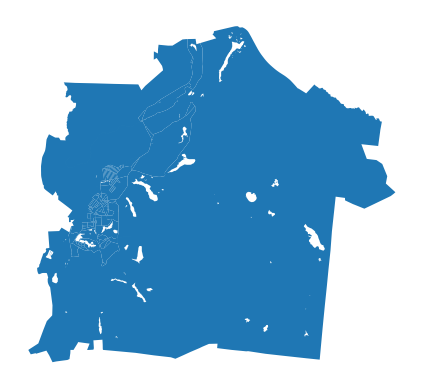

In [134]:
blocks.plot().set_axis_off()

### Получение матрицы

Её получим не из БД, а средствами блокснета

In [135]:
from blocksnet.relations.accessibility import get_accessibility_graph

graph = get_accessibility_graph(blocks, 'intermodal')

2025-06-13 03:20:14.749 | WARNING  | blocksnet.relations.accessibility.graph:get_accessibility_graph:14 - CRS do not match IDUEDU required crs. Reprojecting
2025-06-13 03:20:14.778 | INFO     | iduedu.modules.drive_walk_builder:get_walk_graph:217 - Downloading walk graph from OSM, it may take a while for large territory ...


Calculating the weights of the walk graph:   0%|          | 0/2440 [00:00<?, ?it/s]

Parsing public transport routes:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-13 03:20:18.255 | INFO     | iduedu.modules.pt_walk_joiner:join_pt_walk_graph:51 - Composing intermodal graph...
2025-06-13 03:20:18.314 | WARNING  | iduedu.utils.utils:remove_weakly_connected_nodes:37 - Removing 6 nodes that form 3 trap components. These are groups where you can enter but can't exit (or vice versa). Keeping the largest strongly connected component (935 nodes).


In [136]:
from blocksnet.relations.accessibility import calculate_accessibility_matrix

acc_mx = calculate_accessibility_matrix(blocks, graph)
acc_mx.head()

/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,0.00000,75.0000,60.8750,252.000,43.46875,48.65625,69.68750,84.75000,90.5000,88.00000,88.87500,89.25000,96.5000,101.6250,91.31250,94.1875,104.0000,89.9375,99.4375,104.18750,36.62500,43.71875,38.81250,35.37500,21.078125,25.75000,75.000000,70.7500,73.3750,72.2500,87.1875,95.8125,96.25000,101.8125,102.2500,105.1250,102.6875,106.7500,108.1250,93.06250,...,76.687500,81.56250,74.062500,73.62500,74.50000,87.1875,79.500000,82.5000,72.18750,72.75000,73.68750,80.562500,83.500000,81.06250,85.18750,86.12500,73.06250,86.12500,81.250000,71.1875,76.500000,82.2500,78.31250,72.06250,73.18750,68.000000,164.5000,69.250000,76.68750,78.00000,77.000000,78.875000,77.8125,77.31250,64.75000,66.500000,123.1250,104.68750,227.5,228.000
1,75.00000,0.0000,99.6875,291.000,82.31250,87.50000,108.50000,123.56250,129.2500,126.87500,127.68750,128.12500,135.3750,140.5000,130.12500,133.0000,142.8750,128.7500,138.2500,143.00000,42.25000,49.34375,77.62500,74.18750,59.875000,54.62500,7.101562,109.5625,112.1875,111.1250,126.0000,134.7500,135.00000,140.6250,141.1250,143.8750,141.5000,145.6250,147.0000,131.87500,...,115.562500,120.43750,112.875000,112.43750,113.31250,126.0000,118.250000,121.3125,111.00000,111.62500,112.50000,119.375000,122.250000,119.93750,124.00000,125.00000,111.87500,125.00000,120.125000,110.0625,115.312500,121.0625,117.12500,110.87500,112.00000,106.812500,203.2500,108.062500,115.50000,116.81250,115.812500,117.687500,116.6250,116.12500,103.56250,105.375000,161.8750,36.78125,266.5,266.750
2,60.87500,99.6875,0.0000,197.875,42.18750,12.46875,15.56250,30.65625,36.3750,33.90625,34.78125,35.15625,42.3750,47.5625,37.21875,40.0625,49.8750,35.8750,45.3750,50.03125,61.28125,68.37500,26.96875,34.09375,41.000000,50.43750,99.687500,69.5000,19.2500,18.1875,33.0625,41.7500,42.09375,47.6875,48.1875,51.0000,48.5625,52.6875,54.0625,38.90625,...,22.578125,27.46875,19.953125,18.78125,19.65625,33.1250,25.359375,28.3750,17.34375,18.65625,18.84375,26.421875,29.359375,26.96875,31.03125,32.03125,18.21875,32.03125,27.140625,16.3750,22.390625,28.1250,23.46875,17.21875,18.34375,13.171875,110.3125,14.390625,21.84375,23.15625,22.203125,24.015625,23.0000,22.46875,9.90625,11.695312,69.0000,129.37500,173.5,173.875
3,252.00000,291.0000,197.8750,0.000,233.37500,203.62500,192.87500,180.75000,173.2500,174.50000,173.25000,173.62500,178.7500,172.2500,175.37500,174.7500,171.0000,177.5000,174.0000,176.75000,252.37500,259.50000,218.25000,225.25000,232.125000,241.62500,290.750000,260.5000,191.3750,191.1250,169.0000,164.2500,170.12500,172.3750,170.2500,172.2500,178.0000,178.2500,179.0000,182.00000,...,190.750000,193.12500,189.250000,195.25000,199.50000,197.7500,184.375000,187.3750,194.25000,190.00000,194.87500,185.500000,188.375000,186.00000,190.00000,191.00000,199.00000,191.00000,192.750000,194.5000,188.000000,193.7500,197.25000,199.00000,194.87500,198.625000,213.5000,199.625000,196.50000,199.00000,199.625000,197.750000,200.3750,200.25000,200.37500,202.000000,182.3750,320.50000,0.0,0.000
4,43.46875,82.3125,42.1875,233.375,0.00000,30.00000,51.03125,66.06250,71.8125,69.37500,70.18750,70.56250,77.8125,83.0000,72.62500,75.5000,85.3125,71.3125,80.7500,85.50000,43.90625,51.00000,18.00000,14.12500,23.593750,33.03125,82.312500,49.1250,54.6875,53.6250,68.5000,77.1875,77.56250,83.1250,83.5625,86.4375,84.0000,88.1250,89.4375,74.37500,...,58.000000,62.90625,55.375000,54.93750,55.81250,68.5625,60.812500,63.8125,53.46875,54.06250,55.00000,61.875000,64.812500,62.40625,66.50000,67.43750,54.37500,67.43750,62.593750,52.5625,57.843750,63.5625,59.65625,53.37500,54.50000,49.312500,145.7500,50.562500,58.00000,59.31250,58.343750,60.187500,59.1250,58.62500,46.03125,47.843750,104.4375,112.00000,209.0,209.250


### Получение слоя зданий и агрегация

Таким образом получаем население

In [137]:
from blocksnet.blocks.aggregation import aggregate_objects

buildings = get_territory_buildings(TERRITORY_ID).to_crs(blocks.crs)
blocks_buildings, _ = aggregate_objects(blocks, buildings)
blocks = blocks.join(blocks_buildings[['population']])

2025-06-13 03:20:24.742 | INFO     | blocksnet.blocks.aggregation.core:_preprocess_input:12 - Preprocessing input
2025-06-13 03:20:24.743 | INFO     | blocksnet.blocks.aggregation.core:aggregate_objects:41 - Aggregating objects


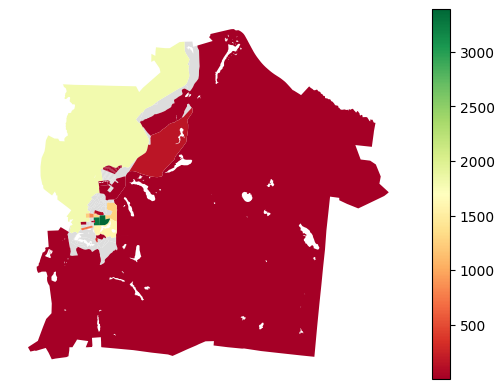

In [138]:
ax = blocks[blocks.population == 0].plot(color='#ddd')
blocks[blocks.population > 0].plot('population', ax=ax, legend=True, cmap='RdYlGn').set_axis_off()

### Получение слоев сервисов и их агрегация

Таким образом получаем нужные капасити

In [139]:
for service_type, row in service_types.iterrows():
    file_name = f'{service_type}.geojson'
    service_gdf = gpd.read_file(f'./data/{file_name}')[['geometry', 'capacity']].reset_index(drop=True)
    service_gdf = service_gdf.to_crs(blocks.crs)

    if 'capacity' not in service_gdf.columns:
        service_gdf['capacity'] = row['capacity']
    else:
        service_gdf['capacity'] = service_gdf['capacity'].fillna(row['capacity'])
    
    blocks_services, _ = aggregate_objects(blocks, service_gdf)
    blocks = blocks.join(blocks_services[['capacity']].rename(columns={'capacity': f'capacity_{service_type}'}))

2025-06-13 03:20:25.020 | INFO     | blocksnet.blocks.aggregation.core:_preprocess_input:12 - Preprocessing input
2025-06-13 03:20:25.023 | INFO     | blocksnet.blocks.aggregation.core:aggregate_objects:41 - Aggregating objects


### Результат

В результате у нас есть:

- `acc_mx` -- матрица доступности
- `blocks` -- геодатафрейм кварталов со следующими столбцами:
  - `geometry` -- геометрия
  - `population` -- население в квартале
  - `capacity_{service_type}` -- капасити разных типов сервисов

## Оценка обеспеченностей

In [141]:
demand, accessibility = service_types.iloc[0][['demand','accessibility']]

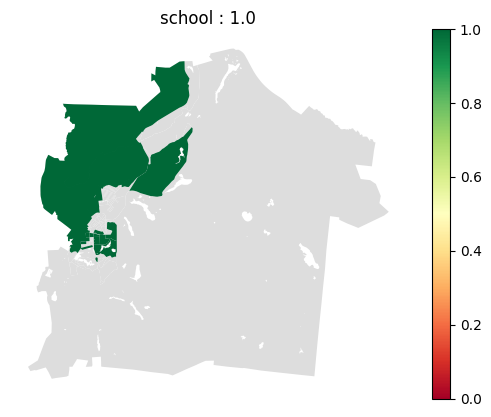

In [150]:
from blocksnet.analysis.provision import competitive_provision, provision_strong_total
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

def plot(prov_df : pd.DataFrame, service_type : str):
    prov_total = provision_strong_total(prov_df)
    title = f'{service_type} : {round(prov_total,2)}'
    gdf = blocks[['geometry']].join(prov_df)
    ax = gdf.plot(color='#ddd')
    gdf.plot('provision_strong', ax=ax, legend=True, cmap='RdYlGn', vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_axis_off()


for service_type, row in service_types.iterrows():
    df = blocks[['population', f'capacity_{service_type}']].rename(columns={f'capacity_{service_type}':'capacity'})
    demand, accessibility = row[['demand', 'accessibility']]
    prov_df, _ = competitive_provision(df, acc_mx, demand, accessibility)
    plot(prov_df, service_type)
    